# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__

![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb../xvfb: line 24: start-stop-daemon: command not found
.


state vector dim = 4
n_actions = 2


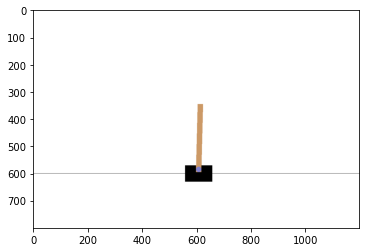

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# if you see "<classname> has no attribute .env", remove .env or update gym
env = gym.make("CartPole-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render("rgb_array"))
print("state vector dim =", state_dim)
print("n_actions =", n_actions)

# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:
* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__


In [3]:
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [4]:
agent.predict_proba(np.array([0, 0, 0, 0]).reshape(1, -1))

array([[0.58991087, 0.41008913]])

In [5]:
def generate_session(env, agent, t_max=1000):
    """
    Play a single game using agent neural network.
    Terminate when game finishes or after :t_max: steps
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):
        
        # use agent to predict a vector of action probabilities for state :s:
        probs = np.squeeze(agent.predict_proba(s.reshape(1, -1)))

        assert probs.shape == (env.action_space.n,), "make sure probabilities are a vector (hint: np.reshape)"
        
        # use the probabilities you predicted to pick an action
        # sample proportionally to the probabilities, don't just take the most likely action
        a = np.random.choice(np.arange(n_actions), p=probs)
        # ^-- hint: try np.random.choice

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.stack(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[-2.8619033e-03  3.4985352e-02 -3.7117355e-02  4.1929197e-02]
 [-2.1621962e-03 -1.5958522e-01 -3.6278769e-02  3.2267407e-01]
 [-5.3539006e-03  3.6034040e-02 -2.9825289e-02  1.8774604e-02]
 [-4.6332199e-03 -1.5864776e-01 -2.9449796e-02  3.0190012e-01]
 [-7.8061754e-03  3.6881268e-02 -2.3411795e-02  7.6738987e-05]]
actions: [0, 1, 0, 1, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a `float32` vector.

In [7]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """


    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states = [j for i, elit in enumerate(states_batch) for j in elit if rewards_batch[i] >= reward_threshold]
    elite_actions = [j for i, elit in enumerate(actions_batch) for j in elit if rewards_batch[i] >= reward_threshold]
    
    return elite_states, elite_actions

# Training loop
Generate sessions, select N best and fit to those.

In [8]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()




mean reward = 758.810, threshold=1000.000


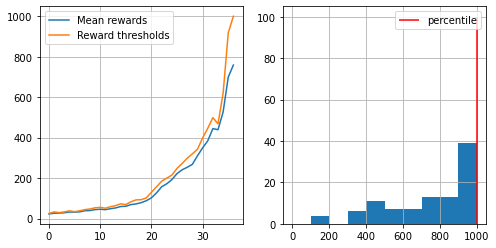

You Win! You may stop training now via KeyboardInterrupt.


KeyboardInterrupt: 

In [9]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    # <YOUR CODE: partial_fit agent to predict elite_actions(y) from elite_states(X)>
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


Okay, let's choise taxi problem from now.

We will use the same policy as we had: ``policy[s, a] = P(take action a | in state s)`` and try to maximize that. It means, that we are miximizing likelyhood of actions `a` by given states `s`.

In [12]:
from tqdm import tqdm

In [13]:
env = gym.make("Taxi-v3")
env.reset()
env.render()

n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    return policy

def generate_session(env, policy, t_max=10**4):
    states, actions = [], []
    total_reward = 0.
    s = env.reset()
    for _ in range(t_max):
        a = np.random.choice(np.arange(n_actions), p=policy[s])

        new_s, r, done, info = env.step(a)
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward


def get_new_policy(elite_states, elite_actions):
    new_policy = np.zeros([n_states, n_actions])
    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1
    new_policy[new_policy.sum(axis=1) == 0] = 1
    new_policy = new_policy / new_policy.sum(axis=1, keepdims=True)
    return new_policy


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

n_states=500, n_actions=6


mean reward = -78.040, threshold=4.500


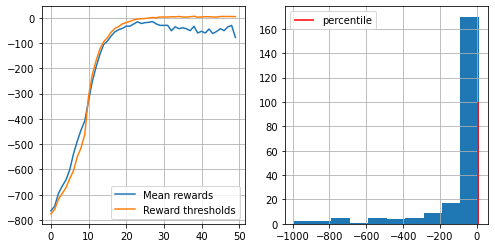

100%|██████████| 50/50 [00:42<00:00,  1.19it/s]


In [14]:
# reset policy just in case
policy = initialize_policy(n_states, n_actions)

n_sessions = 250     # sample this many sessions
percentile = 50      # take this percent of session with highest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in tqdm(range(50)):
    %time sessions = [generate_session(env, policy) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

  We can see, that mean rewards descends back to -100 after ~25 iterrations.

  Let's validate different hyperparams ``n_sessions, percentile, learnign_rate`` 

mean reward = -234.102, threshold=9.000


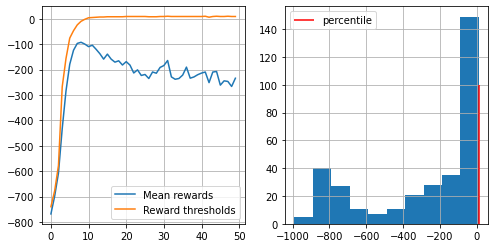

100%|██████████| 4/4 [46:28<00:00, 697.03s/it]


In [20]:

n_sessions_ = [50, 100, 250, 400]     # sample this many sessions
percentile_ = [10, 25, 50, 75]     # take this percent of session with highest rewards
learning_rate_ = [0.1, 0.5, 0.7]  # how quickly the policy is updated, on a scale from 0 to 1

logs = {}

for n_sessions in tqdm(n_sessions_):
    for percentile in percentile_:
        for learning_rate in learning_rate_:
            policy = initialize_policy(n_states, n_actions)
            log = []
            for i in range(50):
                %time sessions = [generate_session(env, policy) for _ in range(n_sessions)]

                states_batch, actions_batch, rewards_batch = zip(*sessions)

                elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

                new_policy = get_new_policy(elite_states, elite_actions)

                policy = learning_rate * new_policy + (1 - learning_rate) * policy

                # display results on chart
                show_progress(rewards_batch, log, percentile)
            key = "ns_" + str(n_sessions) + "_per_" + str(percentile) + "_lr_" + str(learning_rate)
            logs[key] = log[-1]
        

In [25]:
dict(sorted(logs.items(), key=lambda item: item[1])[::-1])

{'ns_400_per_25_lr_0.7': [-4.5625, 1.0],
 'ns_250_per_25_lr_0.7': [-6.712, -3.0],
 'ns_250_per_25_lr_0.5': [-9.46, -14.0],
 'ns_250_per_50_lr_0.5': [-34.088, 6.0],
 'ns_400_per_25_lr_0.5': [-36.7, -51.0],
 'ns_400_per_75_lr_0.1': [-45.5425, -12.0],
 'ns_400_per_50_lr_0.5': [-54.4375, 7.0],
 'ns_400_per_50_lr_0.7': [-62.6675, 7.0],
 'ns_250_per_75_lr_0.1': [-65.64, -9.0],
 'ns_50_per_25_lr_0.5': [-69.0, -85.0],
 'ns_250_per_50_lr_0.7': [-124.252, 3.0],
 'ns_100_per_50_lr_0.1': [-126.19, -97.0],
 'ns_50_per_50_lr_0.7': [-127.48, -23.0],
 'ns_100_per_25_lr_0.7': [-161.65, -200.0],
 'ns_50_per_25_lr_0.7': [-168.18, -136.25],
 'ns_100_per_50_lr_0.5': [-170.85, -14.0],
 'ns_50_per_50_lr_0.5': [-179.62, -33.0],
 'ns_400_per_75_lr_0.5': [-201.415, 9.0],
 'ns_400_per_50_lr_0.1': [-203.225, -176.0],
 'ns_250_per_50_lr_0.1': [-203.7, -197.0],
 'ns_50_per_50_lr_0.1': [-204.56, -105.0],
 'ns_400_per_75_lr_0.7': [-234.1025, 9.0],
 'ns_100_per_25_lr_0.5': [-239.26, -263.0],
 'ns_100_per_50_lr_0.7': [

<function matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, verts=<deprecated parameter>, edgecolors=None, *, plotnonfinite=False, data=None, **kwargs)>

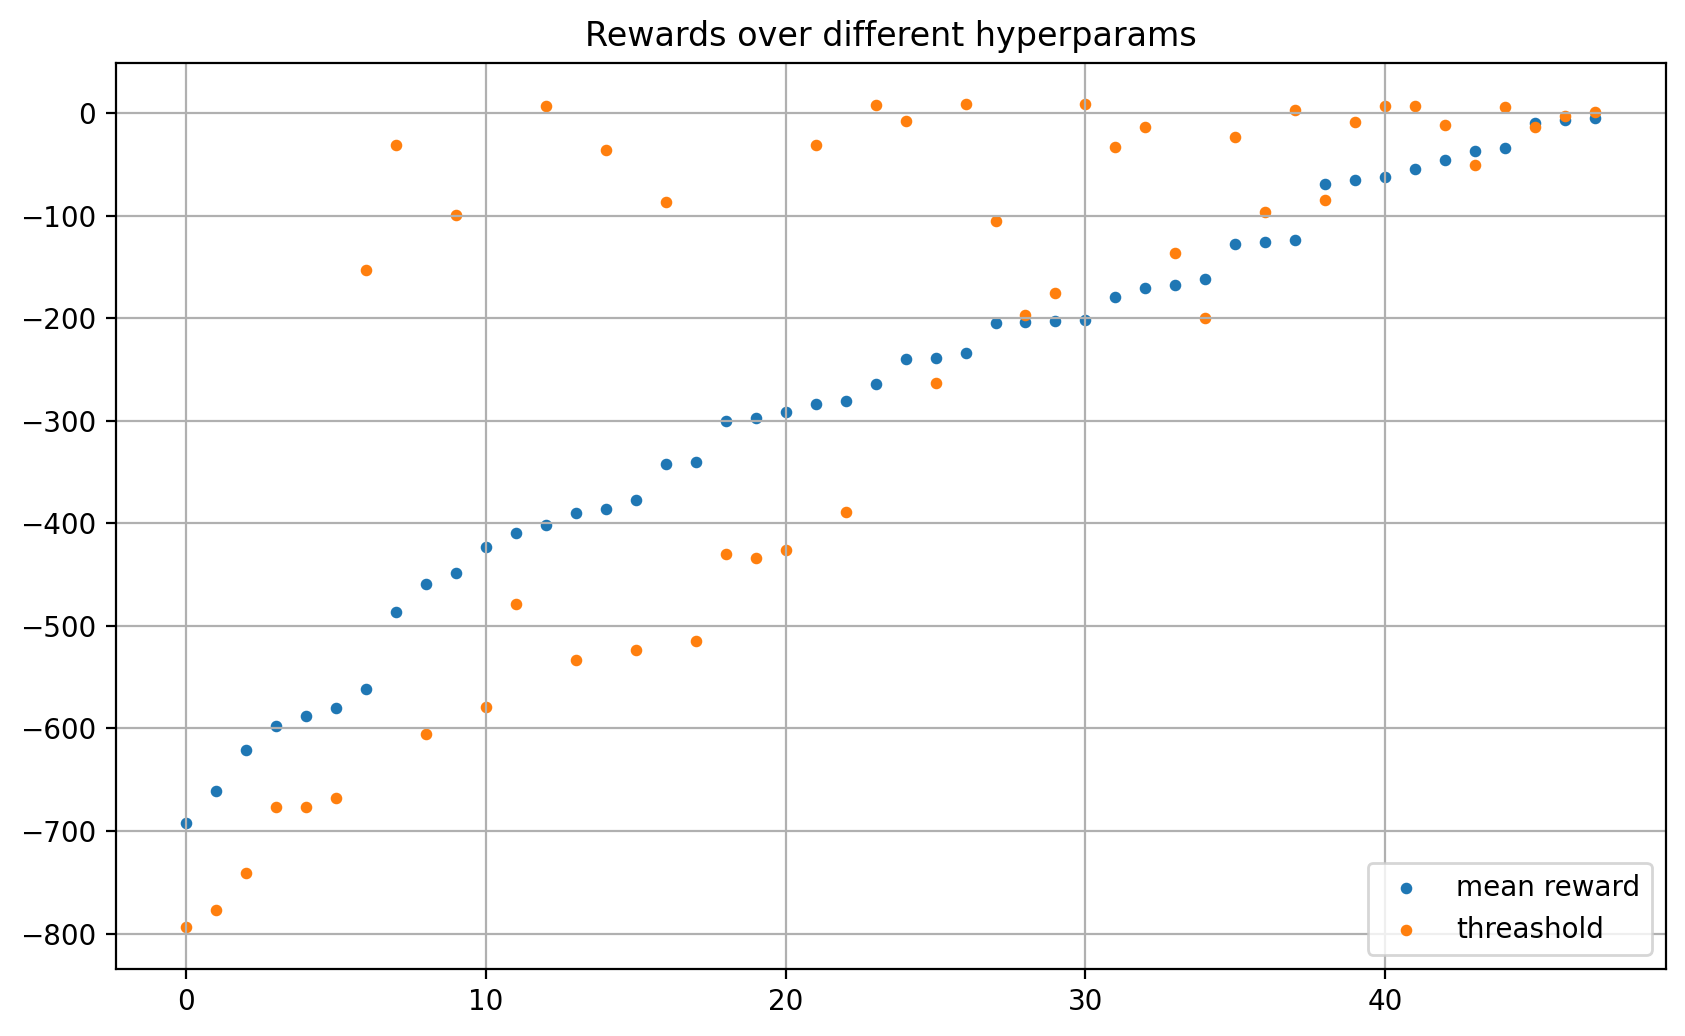

In [54]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 200


rewards_mean = [i[1][0]for i in sorted(logs.items(), key=lambda item: item[1])]
threasholds = [i[1][1]for i in sorted(logs.items(), key=lambda item: item[1])]


plt.scatter(np.arange(48), rewards_mean, s=10, label="mean reward")
plt.scatter(np.arange(48), threasholds, s=10, label="threashold")
plt.grid()
plt.title("Rewards over different hyperparams")
plt.legend(loc="best")
plt.scatter

As we can see, the best hyperparms, which don't allow reward to decent back are ``percentile=25, n_sessions=400, lr=0.7``

Let's tune the algorithm with some more itterrations and (less lr)...

mean reward = 2.092, threshold=5.000


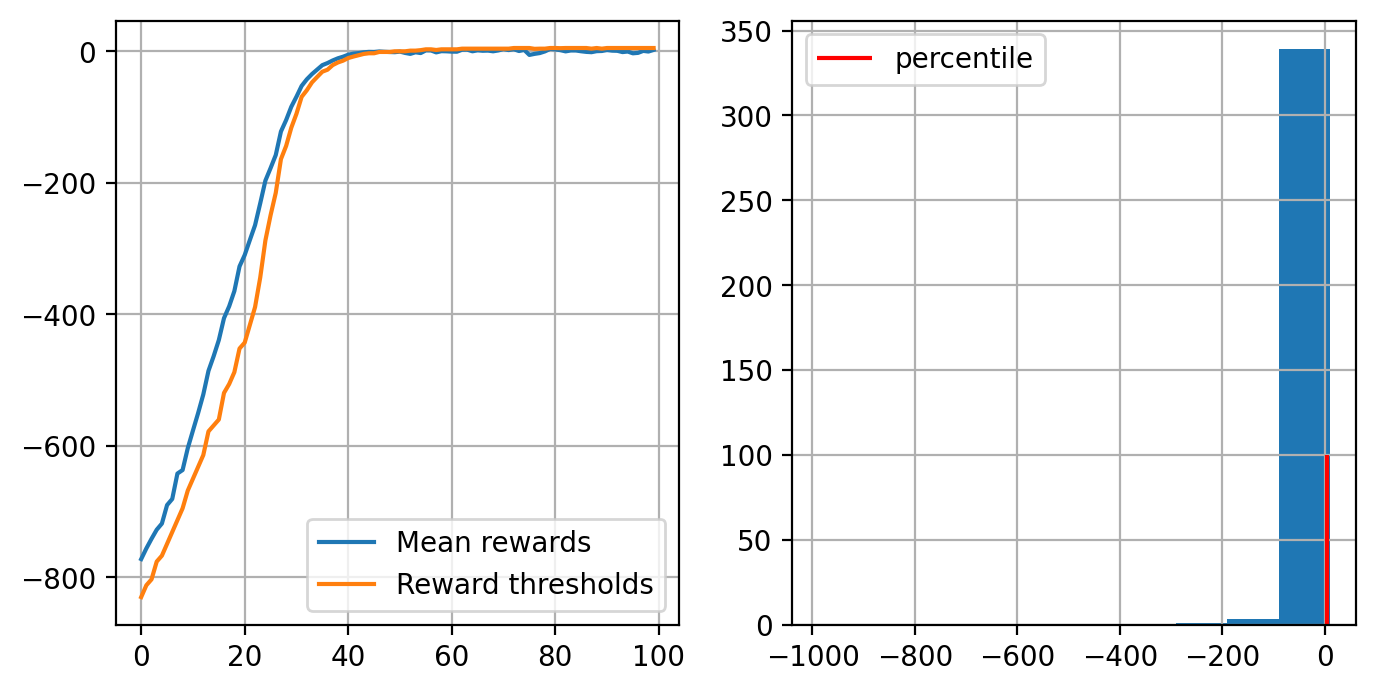

100%|██████████| 100/100 [02:06<00:00,  1.26s/it]


In [55]:
policy = initialize_policy(n_states, n_actions)

n_sessions = 400    # sample this many sessions
percentile = 25      # take this percent of session with highest rewards
learning_rate = 0.6  # how quickly the policy is updated, on a scale from 0 to 1

log = []

for i in tqdm(range(100)):
    %time sessions = [generate_session(env, policy) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = zip(*sessions)

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

    new_policy = get_new_policy(elite_states, elite_actions)

    policy = learning_rate * new_policy + (1 - learning_rate) * policy

    # display results on chart
    show_progress(rewards_batch, log, percentile)

Alright, we've done this!

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gym page: [MountainCar](https://gym.openai.com/envs/MountainCar-v0), [LunarLander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

mean reward = -152.873, threshold=-220.530


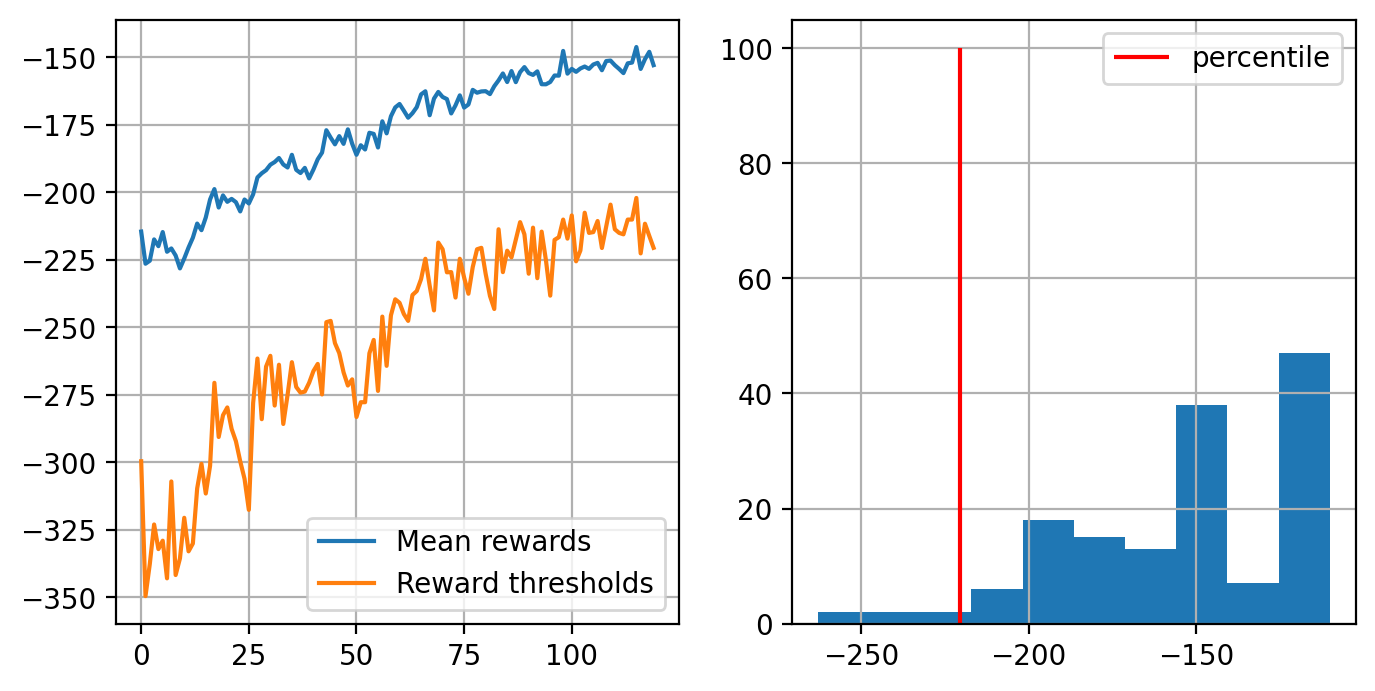

100%|██████████| 120/120 [10:20<00:00,  5.17s/it]


In [86]:
env = gym.make("MountainCar-v0").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

agent = MLPClassifier(
    hidden_layer_sizes=(50, 50),
    activation='tanh',
)

# initialize agent to the dimension of state space and number of actions
agent.partial_fit([env.reset()] * n_actions, range(n_actions), range(n_actions))


def generate_session(env, agent, t_max=10000):
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        probs = np.squeeze(agent.predict_proba(s.reshape(1, -1)))
        
        a = np.random.choice(np.arange(n_actions), p=probs)

        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward
  
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states = [j for i, elit in enumerate(states_batch) for j in elit if rewards_batch[i] > reward_threshold]
    elite_actions = [j for i, elit in enumerate(actions_batch) for j in elit if rewards_batch[i] > reward_threshold]
    
    return elite_states, elite_actions

def show_progress(rewards_batch, log, percentile, reward_range):

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

n_sessions = 150
percentile = 3
log = []

for i in tqdm(range(120)):
    # generate new sessions
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

    if np.mean(rewards_batch) > -150:
        print("You Win! You may stop training now via KeyboardInterrupt.")


Yeah! We've done this (with pain)! We achive -150. It mean that our agent "understands" how to play this game.

Some points:
- I trained perceptron with 20x20 h.l. -- too less params.
- For the first iterations we need bigger `perceptil` (it's like learning rate in the first iterations).
- Then I changed `percentile` from `50->25->10->5->3`. It works fine!
- DO NOT change `n_sessions`! Your model will dramatically changed as well. I did and it ended up with `-150` to mean rewards( 

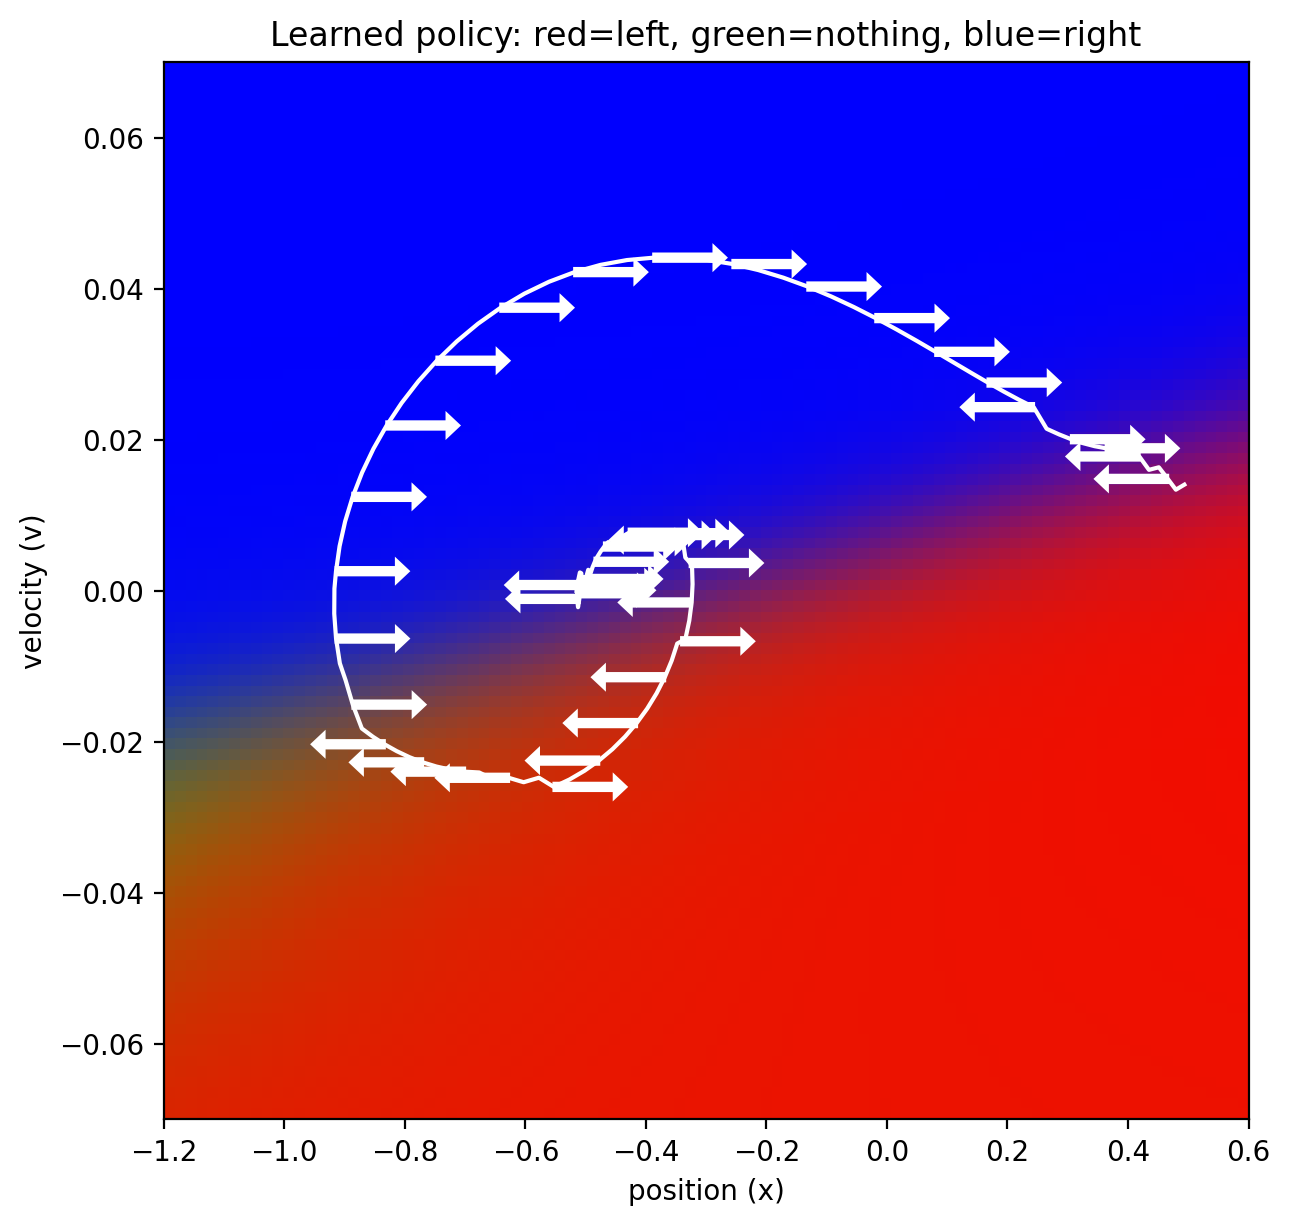

In [88]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    
    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(probs, extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed), aspect='auto')
    ax.set_title('Learned policy: red=left, green=nothing, blue=right')
    ax.set_xlabel('position (x)')
    ax.set_ylabel('velocity (v)')
    
    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color='white')
    
    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color='white', head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color='white', head_length=0.02)

with gym.make('MountainCar-v0').env as env:
    visualize_mountain_car(env, agent)

Let's make it faster!

As it was suggested, we'll use joblib. AND (which gives more advantage) use different policy from different states.

mean reward = -99.948, threshold=-98.000


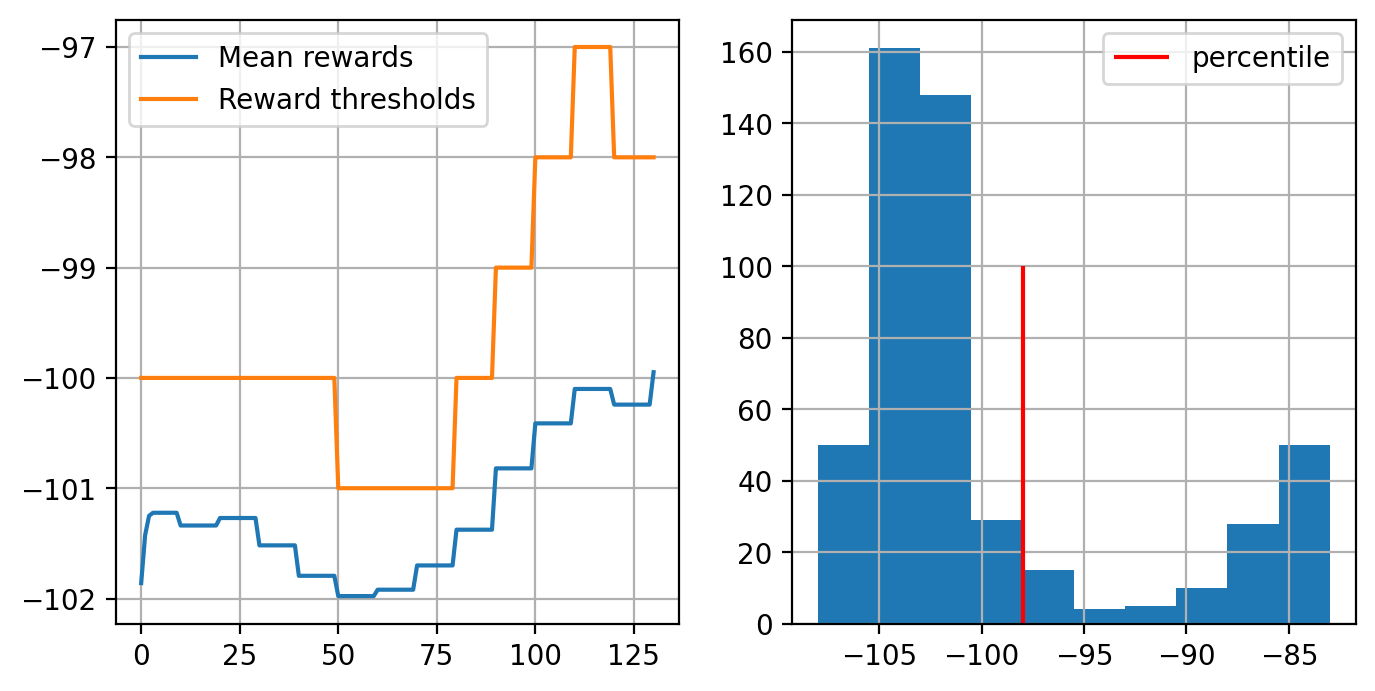

 22%|██▏       | 130/600 [01:25<05:09,  1.52it/s]

You Win! You may stop training now via KeyboardInterrupt.


In [168]:
from joblib import Parallel, delayed

def generate_session(env, agent, t_max=20000):
    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(t_max):

        probs = np.squeeze(agent.predict_proba(s.reshape(1, -1)))
        
        a = np.random.choice(np.arange(n_actions), p=probs)

        new_s, r, done, info = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward
  
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    elite_states = [j for i, elit in enumerate(states_batch) for j in elit if rewards_batch[i] > reward_threshold]
    elite_actions = [j for i, elit in enumerate(actions_batch) for j in elit if rewards_batch[i] > reward_threshold]
    
    return elite_states, elite_actions

def show_progress(rewards_batch, log, percentile, reward_range):
    
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

n_sessions = 100
percentile = 79
log = []

sessions_ = []

for i in tqdm(range(600)):
    if i % 10 == 0 or i in [0, 1, 2, 3]:
        sessions = [generate_session(env, agent) for _ in range(n_sessions)]
        sessions_.extend(sessions)
    if i <= 3:
        states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions_))
    else:
        states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions_[-500::]))
    
    with Parallel(n_jobs=-1) as parallel:
        elite_states, elite_actions = parallel(delayed(select_elites)(states_batch, actions_batch, rewards_batch, percentile)
    
    agent.partial_fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[np.min(rewards_batch), np.max(rewards_batch)])

    if np.mean(rewards_batch) > -100:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break

We've done this! Without a lot of pain, but still I've faced some issues.

- I increased `persentile` and it started working after some iterrations. I wish I had more patince (not to interupt traing loop).
- Use multithreading.
- The most expensive procedure is to sample sessions, hence I sample 1/10 iters, on others I use previous good samples. I mean model doen't fit enough in 1 iteration it needs more.

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gym.openai.com/envs/MountainCarContinuous-v0) (90+ pts to solve), [LunarLanderContinuous-v2](https://gym.openai.com/envs/LunarLanderContinuous-v2) (200+ pts to solve) 
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.

Let's do bonus tasks in different notebook and use gpus for NN